In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

Global seed set to 42


In [2]:


import pandas as pd
import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)

from models import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader)

Global seed set to 42


# Utility functions and classes

# Set Root Path to local disk

In [3]:
ROOT_PATH = 'c:/Users/gilbe/Documents/TokyoData'

# Start data analysis 

### API data

In [4]:
'/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv'
'/train_files/trades.csv'

train_df = pd.read_csv(f'{ROOT_PATH}/train_files/stock_prices.csv')
train_df['Date'] = pd.to_datetime(train_df['Date']) 
train_df.set_index('Date', inplace=True)
# train_df = date_features(train_df)

train_options = pd.read_csv(f'{ROOT_PATH}/train_files/options.csv', low_memory=False)
train_financials = pd.read_csv(f'{ROOT_PATH}/train_files/financials.csv', low_memory=False)
train_trades = pd.read_csv(f'{ROOT_PATH}/train_files/trades.csv', low_memory=False)

In [5]:
print(train_df.shape)
print()
print('Unique values for Adjustment factor:')
print(train_df.AdjustmentFactor.unique())
print()
print('Number of Unique Securities code:')
print(train_df.SecuritiesCode.nunique())
print()
print('Number of Unique Expected dividends:')
print(train_df.ExpectedDividend.nunique())
# print(train_df.ExpectedDividend.unique())
show_df(train_df, dataframe_name='stock_data')

show_df(train_options, dataframe_name='options_data')

show_df(train_financials, dataframe_name='financials')

show_df(train_trades, dataframe_name='trades')

(2332531, 11)

Unique values for Adjustment factor:
[ 1.          0.5         5.          0.33333333  0.83333333  0.25
  0.90909091  0.1        10.          0.2         0.95238095  2.
  0.14285714  0.66666667  0.86956522  0.76923077  0.8         4.
 20.        ]

Number of Unique Securities code:
2000

Number of Unique Expected dividends:
446
<<< stock_data >>>
(2332531, 11)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   SecuritiesCode    int64  
 2   Open              float64
 3   High              float64
 4   Low               float64
 5   Close             float64
 6   Volume            int64  
 7   AdjustmentFactor  float64
 8   ExpectedDividend  float64
 9   SupervisionFlag   bool   
 10  Target            float64
dtypes: bool(1), float64(7), int64(2), object(1)
memory usage: 198.0+ MB
None
             

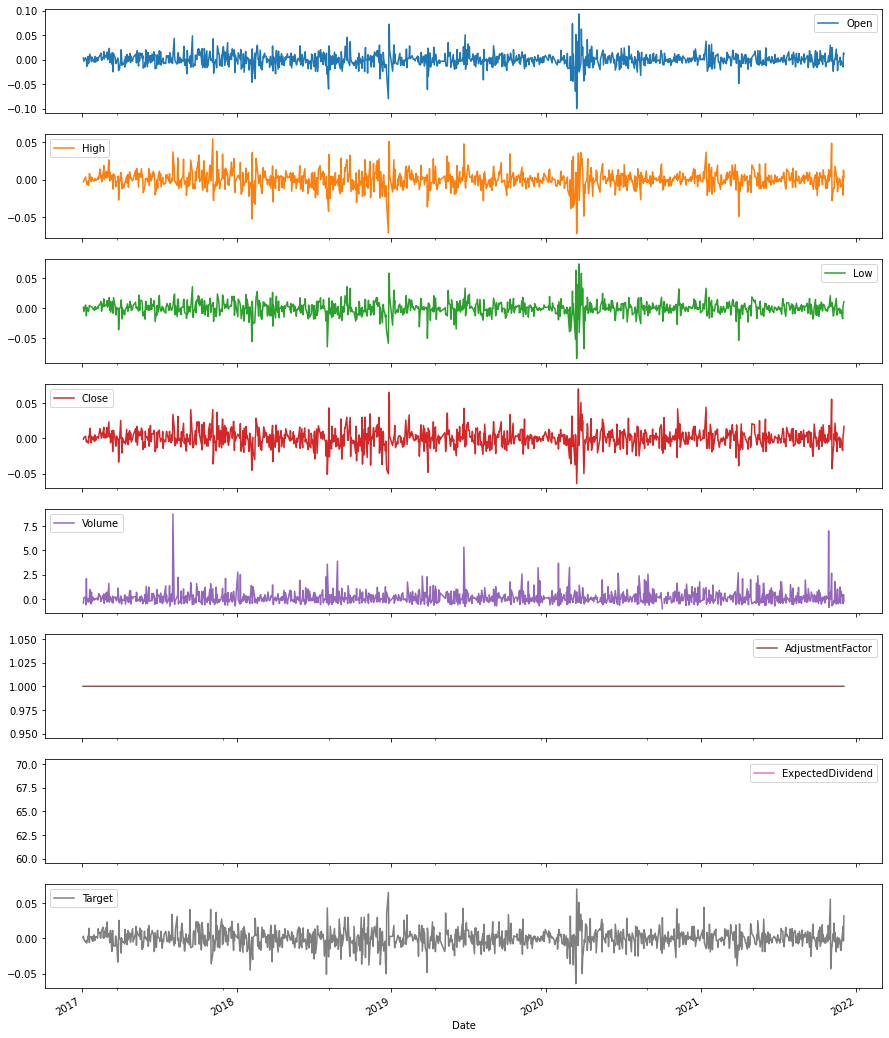

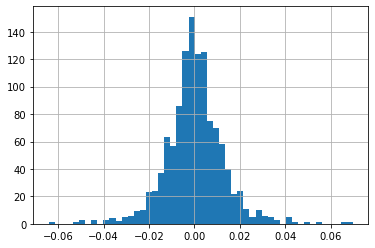

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1202 entries, 2017-01-04 to 2021-12-03
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1201 non-null   float64
 1   High              1201 non-null   float64
 2   Low               1201 non-null   float64
 3   Close             1201 non-null   float64
 4   Volume            1201 non-null   float64
 5   AdjustmentFactor  1202 non-null   float64
 6   ExpectedDividend  5 non-null      float64
 7   Target            1202 non-null   float64
dtypes: float64(8)
memory usage: 84.5 KB
None


In [6]:
import matplotlib.pyplot as plt

df_1301 = train_df[train_df['SecuritiesCode'] == 1301].drop('SecuritiesCode', axis=1)
# df_1301.set_index('Date', inplace=True)
# df_1301[['Open', 'Close', 'High', 'Low', 'Volume']] = df_1301[['Open', 'Close', 'High', 'Low', 'Volume']].pct_change()
df_1301 = preprocess(df_1301)
df_1301.plot(figsize=(15, 20), subplots=True);
plt.show();
df_1301.Target.hist(bins=50);
plt.show();


# pd.plotting.scatter_matrix(df_1301);
# plt.show();
print(df_1301.info())

## Models
Todo:

    1) Preprocesses data and use correct features (date features, etc)
    2) Deep learning for prediction of stock-returns
    3) Ranking with XGBoost or other methods

In [7]:
import torch
from sklearn.impute import SimpleImputer


ytrain_stock = df_1301['Target'].to_numpy()
xtrain_stock = df_1301.dropna().drop('Target', axis=1).to_numpy()

print(ytrain_stock.shape)
print('target:', ytrain_stock)

print()
print(xtrain_stock.shape)
print('xtrain:', xtrain_stock)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

xtrain_stock = imp.fit_transform(xtrain_stock)



train_dataloader = get_loader(xtrain_stock, ytrain_stock, 64)


# train_set = TimeSeriesDataset(x_num, y_num)
# train_loader = DataLoader(train_set, batch_size=64)
model = NeuralNetwork(in_features=xtrain_stock.shape[1], out_features=1)
trainer = Trainer(model, lr=3e-6)
trainer.fit_one_epoch(train_dataloader)

# # Display image and label.
# train_features, train_labels = next(iter(train_dataloader))
# print(train_features['features'])
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# # img = train_features[0].squeeze()
# # label = train_labels[0]
# # plt.imshow(img, cmap="gray")
# # plt.show()
# # print(f"Label: {label}")

(1202,)
target: [ 0.00073046  0.00291971 -0.0010917  ...  0.01670644 -0.0036888
  0.03163918]

(5, 7)
xtrain: [[ 3.21027287e-03 -1.59235669e-03 -1.60513644e-03 -1.60000000e-03
   4.24242424e-01  1.00000000e+00  6.00000000e+01]
 [-1.17493473e-02  5.20833333e-03 -5.26315789e-03  1.17955439e-02
   1.61375661e-01  1.00000000e+00  6.00000000e+01]
 [-8.22368421e-03 -1.64203612e-03 -1.66666667e-03  8.29187396e-03
   1.82027650e-01  1.00000000e+00  6.00000000e+01]
 [ 9.52380952e-03  1.68602473e-02  4.63499421e-03  9.76342471e-03
   3.15789474e-01  1.00000000e+00  7.00000000e+01]
 [ 1.08864697e-02  1.07692308e-02  9.33125972e-03  4.62962963e-03
   4.62462462e-01  1.00000000e+00  7.00000000e+01]]
Using cuda-device
x-tesnor-shape: torch.Size([5, 7])
y-tensor-shape: torch.Size([5, 1])
loss: 3.0621249675750732 [0/1]
